# Projeto de aplicação do Active Learning

In [ ]:
# Realizando o carregamento das bibliotecas que serão utilizadas no desenvolvimento do programa
import numpy as np #biblioteca para utilização de variáveis com multidimenções e vetores
import tensorflow as tf #biblioteca para desenvolvimento de modelo de machine learning
import matplotlib as mpl #biblioteca para visualização de gráficos e figuras
import matplotlib.pyplot as plt
%matplotlib inline

"""
Teste
"""

'''
Teste
'''

In [ ]:
mnist = tf.keras.datasets.mnist #Carregando o database do mnist a partir da biblioteca do tensorflow, essa biblioteca já está em modo vetor em arquivos .csv com 10 mil amostras para teste e 20 mil para treinamento.
(x_train, y_train), (x_test, y_test) = mnist.load_data() #carregando e separando os dados nas variáveis de treino e teste
x_train, x_test = x_train / 255.0, x_test / 255.0 #Realizando a normalização dos dados

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Função para priorizar as amostas que são mais difíceis de classificar,
# ou seja que possuem a acuracia mais baixa, dessa forma o modelo ganha
# vantagem no aprendizado utilizando menos amostras no aprendizado.
def eval_prioritization_strategy(prioritizer): # Definição da função de estratégia de priorização de amostras
  train_indices = range(60000) #representa os indices da variável de treinamento que será utlizada na seleção das amostras

  test_accuracies = [] # declaração da variável como vetor
  x_train_subset = np.zeros([0, 28, 28]) # Cria uma matriz numpy de zeros com uma forma de [0, 28, 28].
                                          # Irá conter um subconjunto de imagens de treino mais tarde.
  y_train_subset = np.empty([0,]) #Cria uma matriz vazia para guardar um subconjunto de etiquetas de treino.


  for i in range(40):
    selected_indices = train_indices[0:500] #Seleciona os primeiros 500 índices da lista train_indices e armazena.
    train_indices = train_indices[500:] #Remove os primeiros 500 elementos da lista train_indices,
                                        # mantendo apenas os índices restantes para a próxima iteração.
    x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...])) # Concatena as imagens de treino correspondentes aos índices_seleccionados ao conjunto x_train_subset existente.
    y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...])) # Concatena os rótulos de treino correspondentes aos índices_seleccionados ao conjunto de dados y_train_subset existente.

    model = tf.keras.models.Sequential([ # Cria o modelo sequencial com três camadas
      tf.keras.layers.Flatten(input_shape=(28, 28)), #Vetoriza imagens de entrada de 28x28 píxeis para uma única dimensão.
      tf.keras.layers.Dense(128, activation='relu'), # Cria uma camada oculta com 128 neurónios e ativação ReLU.
      tf.keras.layers.Dense(10, activation='softmax') # Cria uma camada de saída com 10 neurónios (um para cada classe) e ativação Softmax para classificação.
    ])

    model.compile(optimizer='adam', # Configura o modelo com otimizador (Adam), função de perda (Sparse Categorical Cross-entropy) e métrica (Accuracy).
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0) # Treina o modelo no x_train_subset e y_train_subset para 5 épocas sem imprimir registos de progresso (verbose=0).
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0) # Avalia o modelo treinado nos dados de teste separados (x_teste, y_teste) e armazena os valores de perda e precisão.
    test_accuracies.append(accuracy) # Anexa a precisão alcançada nos dados de teste à lista test_accuracies.
    print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy)) #Imprime informações sobre o tamanho dos dados de treinamento e a precisão alcançada nos dados de teste para cada iteração.

    predictions = model.predict(x_train[train_indices,...]) # Prevê as probabilidades de classe para os dados de treinamento restantes usando o modelo treinado.
    train_indices = prioritizer(train_indices, predictions) # Esta linha usa a função prioritizer para atualizar os índices_treino com base nas probabilidades de classe previstas.

  return test_accuracies # A função devolve a lista de exactidões de teste obtidas em todas as iterações. Isto permite analisar o desempenho da estratégia de priorização ao longo do tempo.

In [ ]:
unprioritized_accuracies = eval_prioritization_strategy(lambda indices, pred: indices) # Esta linha chama a função eval_prioritization_strategy() com a função de priorização lambda indices, pred: indices como parâmetro.
                                                                                       # Esta lambda simplesmente retorna os índices de dados de treinamento originais.

Training data size of 500 => accuracy 0.823900
1860/1860 [==============================] - 5s 2ms/step
Training data size of 1000 => accuracy 0.870700
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.888300
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.888800
1813/1813 [==============================] - 4s 2ms/step
Training data size of 2500 => accuracy 0.910600
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.910500
1782/1782 [==============================] - 4s 2ms/step
Training data size of 3500 => accuracy 0.910100
1766/1766 [==============================] - 4s 2ms/step
Training data size of 4000 => accuracy 0.920000
1750/1750 [==============================] - 5s 3ms/step
Training data size of 4500 => accuracy 0.927200
1735/1735 [==============================] - 4s 2ms/step
Training data size of 5000 => accuracy 0.931400
1719/171

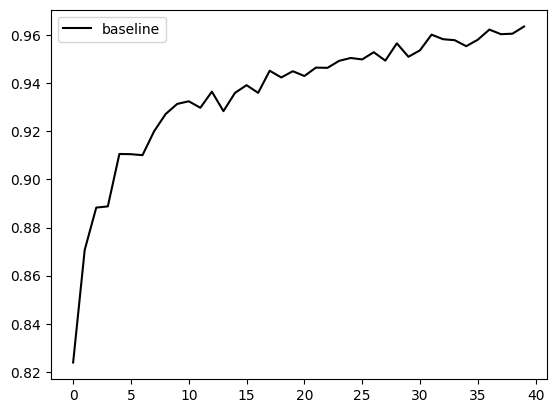

In [ ]:
# plota os dados de acurácia de teste usando um marcador preto e uma linha sólida. O rótulo baseline é usado para identificar a linha.
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.legend()

In [ ]:
# Essa função prioriza os pontos de dados com a menor confiança prevista (maior incerteza) para a próxima iteração de treinamento.

def least_confidence_prediction_prioritizer(indices, predictions):
  max_logit = list(zip(indices, np.amax(predictions,axis=1))) # np.amax(previsões,eixo=1): Encontra a pontuação máxima de logit (uma medida de confiança de previsão) para cada ponto de dados em todas as classes. Considera a linha inteira (eixo=1) de cada probabilidade de previsão na matriz de previsões.
  max_logit.sort(key=lambda x: x[1]) # Isto ordena a lista de tuplas (max_logit) por ordem ascendente com base no segundo elemento, que é a pontuação máxima de logit.
  return list(zip(*max_logit))[0]

In [ ]:
least_confidence_accuracies = eval_prioritization_strategy(least_confidence_prediction_prioritizer)

Training data size of 500 => accuracy 0.821400
1860/1860 [==============================] - 5s 3ms/step
Training data size of 1000 => accuracy 0.856200
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.895400
1829/1829 [==============================] - 5s 2ms/step
Training data size of 2000 => accuracy 0.906800
1813/1813 [==============================] - 3s 2ms/step
Training data size of 2500 => accuracy 0.926100
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.933100
1782/1782 [==============================] - 4s 2ms/step
Training data size of 3500 => accuracy 0.944600
1766/1766 [==============================] - 3s 2ms/step
Training data size of 4000 => accuracy 0.951400
1750/1750 [==============================] - 3s 2ms/step
Training data size of 4500 => accuracy 0.955700
1735/1735 [==============================] - 4s 2ms/step
Training data size of 5000 => accuracy 0.953800
1719/171

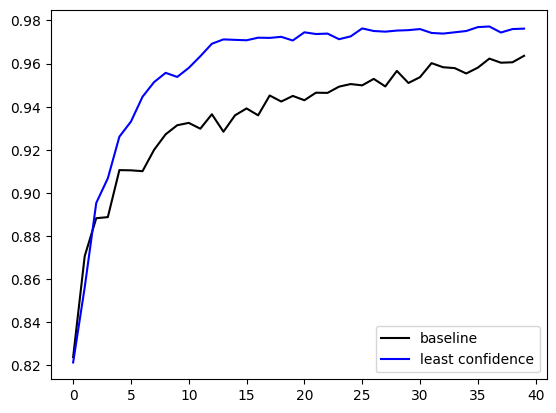

In [ ]:
# Plotando novamente os dados k = preto, b = blue
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.legend()

In [ ]:
'''
Em geral, esta função dá prioridade aos pontos de dados com a entropia mais elevada
(maior incerteza) para a próxima iteração de treino. O modelo concentrar-se-á em aprender
a partir de exemplos com as previsões mais ambíguas primeiro, melhorando potencialmente o
seu desempenho em casos diversos e desafiantes.
'''

def entropy_prioritizer(indices, predictions):
  p = predictions * np.log(predictions)
  p = -p.sum(axis=1) # Leva a soma negativa dos valores em cada linha (eixo=1) da matriz p. Isso calcula efetivamente a entropia de Shannon para cada ponto de dados. A entropia mede a incerteza associada a uma distribuição de probabilidade, com valores mais altos indicando maior incerteza.
  p = list(zip(indices, p))
  p.sort(reverse=True, key=lambda x : x[1]) # sort in descending order
  return list(zip(*p))[0]

In [ ]:
entropy_prioritized_accuracies = eval_prioritization_strategy(entropy_prioritizer)

Training data size of 500 => accuracy 0.825900
1860/1860 [==============================] - 7s 4ms/step
Training data size of 1000 => accuracy 0.845300
1844/1844 [==============================] - 3s 2ms/step
Training data size of 1500 => accuracy 0.882000
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.902200
1813/1813 [==============================] - 4s 2ms/step
Training data size of 2500 => accuracy 0.919500
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.922100
1782/1782 [==============================] - 3s 2ms/step
Training data size of 3500 => accuracy 0.935900
1766/1766 [==============================] - 4s 2ms/step
Training data size of 4000 => accuracy 0.938200
1750/1750 [==============================] - 3s 2ms/step
Training data size of 4500 => accuracy 0.948800
1735/1735 [==============================] - 3s 2ms/step
Training data size of 5000 => accuracy 0.954200
1719/171

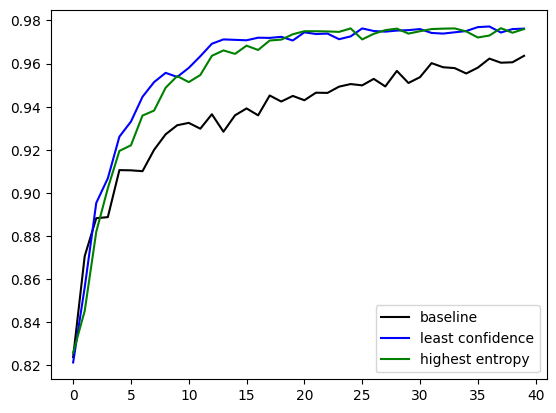

In [ ]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.legend()

In [ ]:
'''
Em essência, o margin_prioritizer prioriza pontos de dados
em que o modelo tem uma "escolha difícil" entre dois concorrentes próximos,
com o objetivo de refinar sua tomada de decisão em situações ambíguas.
'''
def margin_prioritizer(indices, predictions):
  p = -np.sort(-predictions) # sort in descending order
  p = p[:,0] - p[:,1]
  p = list(zip(indices, p))
  p.sort(key=lambda x : x[1]) # sort in ascending order
  return list(zip(*p))[0]

In [ ]:
margin_prioritized_accuracies = eval_prioritization_strategy(margin_prioritizer)

Training data size of 500 => accuracy 0.819800
1860/1860 [==============================] - 6s 3ms/step
Training data size of 1000 => accuracy 0.899300
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.911900
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.929800
1813/1813 [==============================] - 5s 3ms/step
Training data size of 2500 => accuracy 0.938300
1797/1797 [==============================] - 5s 3ms/step
Training data size of 3000 => accuracy 0.952000
1782/1782 [==============================] - 3s 2ms/step
Training data size of 3500 => accuracy 0.953300
1766/1766 [==============================] - 3s 2ms/step
Training data size of 4000 => accuracy 0.956500
1750/1750 [==============================] - 4s 3ms/step
Training data size of 4500 => accuracy 0.955500
1735/1735 [==============================] - 3s 2ms/step
Training data size of 5000 => accuracy 0.961700
1719/171

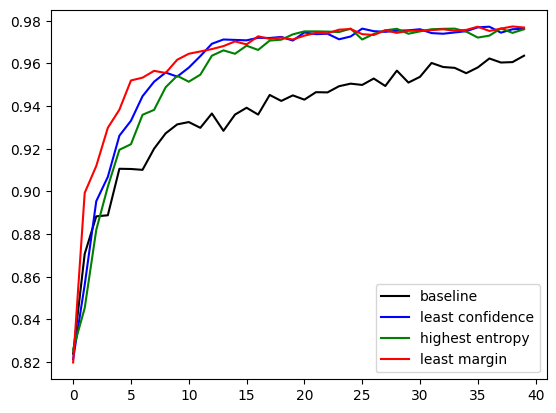

In [ ]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.plot(margin_prioritized_accuracies, 'r', label='least margin')
plt.legend()